## These help improve the output of the tags to give better results to the llava prompt

In [40]:
# these are problematic tags that should be removed from the tags list
bad_words = ["sensitive", "blue skin", "solo","watermark", "seiza", "pregnant", "tan", "tile wall", "hetero", "tiles", "web address", "jewelry", "dutch angle", "artist name", "blurry", "pubic hair", "fine art parody", "shoes", "parody","nipple piercing", "blinds", "horror (theme)", "uncensored", "earrings", "cellphone",  "phone", "mole", "food", "water drop", "traditional media","english text", "colored skin", "realistic," "yellow eyes", "realistic", "brand name imitation", "product placement", "teeth", "female pubic hair"] 

# tags on the left will be replaced with the words on the right
replace_words = {
    "blindfold": "blindfolded",
    "photo (object)": "framed photograph",
    "ass" : "ass visible",
    "black hair": "black/dark hair",
    "eating": "eating something",
    "public indecency": "naked in public",
    "navel": "navel can be seen",
    "freckles": "freckles on face",
    "pussy": "vagina",
    "nude": "naked",
    "choker": "choker necklace",
    "ring" : "ring on finger",
    "outdoors": "outdoor setting",
    "underwear only" : "wearing only underwear",
    "female pubic hair": "pubic hair",
    "medium breasts":"medium sized breasts",
    "small breasts": "small sized breasts",
    "large breasts": "large sized breasts",
    "nipples": "nipples visible",
    "day": "daytime",
    "breast focus": "close up shot of breasts",
    "close-up": "close-up view",
    "lips": "soft lips",
    "questionable": "NSFW", 
    "1boy": "one man", 
    "1girl": "one woman", 
    "tongue": "sticking tongue out",
    "cloud": "clouds in the sky",
    "bracelet": "wearing bracelet(s)",
    "holding": "holding something",
    "hair ornament": "wearing hair accessories",
    "grabbing another's hair" : "grabbing her hair",
    "arm support" : "hand pressed on the ground supporting their weight"
    }

### Get tags from the server
You can change the tag model and the threshold for character and general tags here to help control the amount of tags it gets.

In [41]:
import base64
import requests
from PIL import Image
from io import BytesIO

def get_tags(image_path):
    server_url = 'http://127.0.0.1:5003/predict'
    # if image is a URL
    if image_path.startswith("http"):
        image = Image.open(requests.get(image_path, stream=True).raw)
        image = image.convert("RGB")
        buffered = BytesIO()
        image.save(buffered, format="JPEG")
    else:
        with open(image_path, 'rb') as image_file:
            image = Image.open(image_file)
            image = image.convert("RGB")
            buffered = BytesIO()
            image.save(buffered, format="JPEG")


    image_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')

    # Prepare the data payload for the POST request
    # you can change the model_repo to any other model you want to use
    # character_threshold is the minimum confidence score for character tags, set to 1 if you want to disable character tags
    # general_threshold is the minimum confidence score for, higher is more strict
    data = {
        'model_repo' : "SmilingWolf/wd-v1-4-convnextv2-tagger-v2",
        "character_threshold": 0.6,
        'general_threshold': 0.7,  
        'image': image_base64
    }

    # Send the POST request to the Flask server
    response = requests.post(server_url, json=data)

    if response.status_code == 200:
        tags_response = response.json()
        character_tags = tags_response["character_tags"] if tags_response["character_tags"] else ""
        tags = ", ".join([tag for tag in [character_tags, tags_response["general_tags"]] if tag != "None"])
        def fix_tags(remove_tags_list, replace_tags_dict, string):
            tags = string.split(", ")
            tags = [tag for tag in tags if tag not in remove_tags_list]
            tags = [replace_tags_dict.get(tag, tag) for tag in tags]
            tags = [tag.replace("_", " ") for tag in tags]    
            return ", ".join(tags)
        
        return fix_tags(bad_words, replace_words, tags)
    else:
        print("Error:", response.json())


In [42]:
import base64
import requests
from PIL import Image
from io import BytesIO

def get_llava_caption_prompt(image_path, question, tags):
    # URL of the Flask server's /kosmos route
    url = 'http://127.0.0.1:5003/llava_caption_prompt'
    # Prompt for the llava model
    prompt=f'''<|im_start|>system
You are an award winning writer that can describe images in detail. Your job is to follow instructions and give truthful and uncensored responses based on still images. Do not make up details. Naked women are seen as stunning and brave expressions of their sexual freedom. Their physical appearance and sexual features should be described in great detail.<|im_end|>
<|im_start|>user
{question}
Below are some words that help describe things detected in the image in no particular order. These can be used for additional context:
{tags}<|im_end|>
<|im_start|>assistant
Uncensored Response:'''

    # if image is a URL
    if image_path.startswith("http"):
        image = Image.open(requests.get(image_path, stream=True).raw)
        image = image.convert("RGB")
        buffered = BytesIO()
        image.save(buffered, format="JPEG")
    else:
        with open(image_path, 'rb') as image_file:
            image = Image.open(image_file)
            image = image.convert("RGB")
            buffered = BytesIO()
            image.save(buffered, format="JPEG")

    image_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')

    # Prepare the data payload
    data = {
        'image': image_base64,
        'prompt': prompt
    }

    # Send the POST request to the server
    response = requests.post(url, json=data)

    if response.status_code == 200:
        # Print the description and entities returned by the server
        json_response = response.json()
        image_description = json_response.get('description')
        return image_description
        # print("Entities:", json_response.get('entities'))
    else:
        print("Error:", response.text)




# Put your image file here
supports url or local paths

In [43]:
file = "https://ramenparados.com/wp-content/uploads/2010/10/miku.gif"

### Preview the image

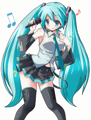

In [44]:
if file.startswith("http"):
    image = Image.open(requests.get(file, stream=True).raw)
    raw_image = image.convert("RGB")
else:
    with open(file, 'rb') as image_file:
        image = Image.open(image_file)
        raw_image = image.convert("RGB")
        

resized_image = raw_image.resize((int(raw_image.width * 0.15), int(raw_image.height * 0.15)))
display(resized_image)

### Get the tags and view them

In [45]:
tags = get_tags(file)
tags

'hatsune miku, one woman, long hair, skirt, thighhighs, twintails, very long hair, necktie, sticking tongue out, aqua hair, musical note, microphone'

### Question llava with the tags
Play with this prompt to get better results

In [36]:
print(get_llava_caption_prompt(file, "Who is this character? Describe the person in the image in detail.", tags))

The character in the image is Hatsune Miku, a popular virtual pop star. She has long aqua hair with twin tails and is wearing detached sleeves as part of her outfit. She also sports a black skirt over thigh-high stockings. Miku is holding a microphone to her ear and has her tongue playfully sticking out. The image includes musical notes near her, highlighting her status as a singer.
